In [1]:
import fastf1
import pandas as pd
import numpy as np
import geopandas as gpd
import folium
from shapely.geometry import LineString, Point
import math
from shapely.affinity import translate
import matplotlib.pyplot as plt
from libpysal import weights
from esda.moran import Moran
from splot.libpysal import plot_spatial_weights
from splot.esda import (
    plot_moran, moran_scatterplot, lisa_cluster, plot_local_autocorrelation,
)
from sklearn.cluster import KMeans,DBSCAN
session = fastf1.get_session(2023, 'Monza', 'R')

req         WARNING 	DEFAULT CACHE ENABLED! (388.51 MB) /Users/flo/Library/Caches/fastf1


In [2]:
session.load(telemetry=True, laps=True, weather=False)

core           INFO 	Loading data for Italian Grand Prix - Race [v3.3.5]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '44', '23', '4', '14', '77', '40', '81', '2', '24', '10', '18', '27', '20', '31', '22']


In [3]:
laps = session.laps
drivers = session.drivers
circuit_info = session.get_circuit_info()
corners_df = circuit_info.corners
lap = session.laps.pick_fastest()
pos = lap.get_pos_data()

In [4]:
track = pd.DataFrame(pos.loc[:, ('X', 'Y')].to_numpy())

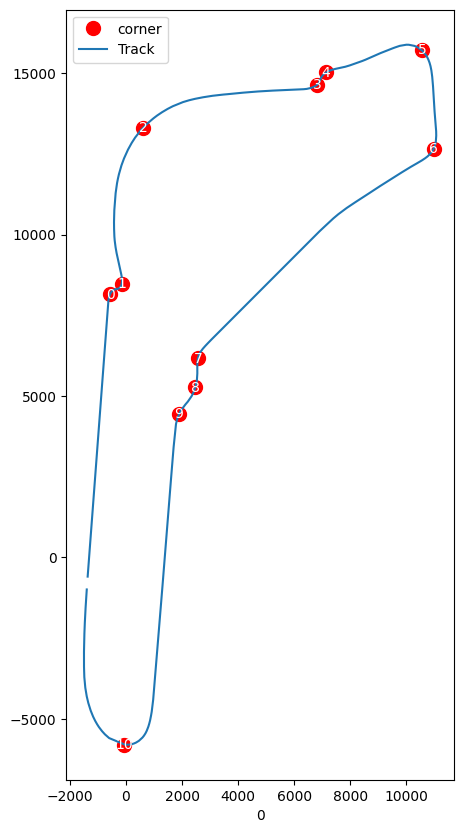

In [5]:
ax = corners_df.plot('X','Y',style = 'o',color = 'red',ms = 10,label = 'corner',figsize = (5,10))
for i, txt in enumerate(corners_df.index):
    ax.annotate(txt, (corners_df['X'][i], corners_df['Y'][i]),ha = 'center', va = 'center',color = 'white')
track.plot(x=0, y=1, ax=ax,label = 'Track');


In [6]:
def euclidean_distance(x1, y1, x2, y2):
    return np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

In [7]:
for i in range(len(corners_df)):
    corner_x = corners_df.iloc[i]['X']
    corner_y = corners_df.iloc[i]['Y']
    
    # Calculate the distance to the current corner for each point
    pos[f'Distance_to_Corner_{i}'] = euclidean_distance(pos['X'], pos['Y'], corner_x, corner_y)
    
    if i == corners_df.index[-1]:
        within_threshold = pos[f'Distance_to_Corner_{i}'] < 2000
    else:
        within_threshold = pos[f'Distance_to_Corner_{i}'] < 500

    
#     # Assign the corner number if within the threshold
    pos.loc[within_threshold, 'Corner_Number'] = int(i)

# # Drop the distance columns if they are no longer needed
pos = pos.drop(columns=[f'Distance_to_Corner_{i}' for i in range(len(corners_df))])

In [8]:
pos = pos.dropna()

In [9]:
corners_min_max = dict()
for i in set(pos['Corner_Number']):
    corner = pos[pos['Corner_Number'] == i]
    min_coords = corner.loc[corner[['X', 'Y']].idxmin().min()]
    max_coords = corner.loc[corner[['X', 'Y']].idxmax().max()]
    corners_min_max[i] = [(min_coords[['X', 'Y']]['X'], min_coords[['X', 'Y']]['Y']),(max_coords[['X', 'Y']]['X'], max_coords[['X', 'Y']]['Y'])]

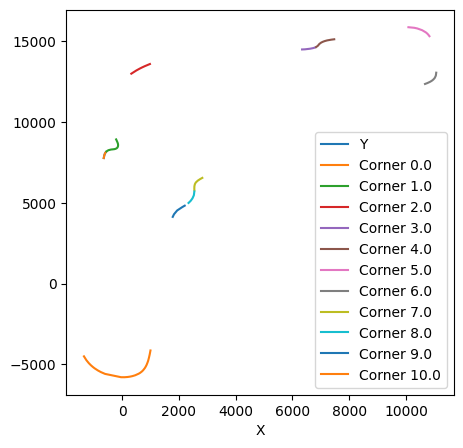

In [10]:
ax = pos[pos['Corner_Number'] == 0].plot(x='X', y='Y', figsize=(5, 5))
def plot_multiple(driver):
    pos[pos['Corner_Number'] == driver ].plot(x = 'X', y = 'Y', ax=ax, label = f'Corner {driver}',figsize = (5,5));
for i in list(set(pos['Corner_Number'].dropna())):
    plot_multiple(i)

In [11]:
telemetry_data = dict()

for driver in drivers:
    driver_telemetry = []
    try:
        driver_laps = laps.pick_driver(driver)
        for lap in driver_laps.iterlaps():
            telemetry = lap[1].get_telemetry()
            telemetry['LapNumber'] = lap[1]['LapNumber']
            driver_telemetry.append(telemetry)
        telemetry_data[driver] = pd.concat(driver_telemetry, ignore_index=True)
    except Exception as e:
        print(f"Error processing driver {driver}: {e}")

core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Z' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'X' while merging telemetry.
core        WARNING 	Failed to preserve data type for column 'Y' while merging telemetry.
core      

KeyboardInterrupt: 

In [ ]:
modified_dfs = []

for key, df in telemetry_data.items():
    df['driver'] = key
    modified_dfs.append(df)

concatenated_df = pd.concat(telemetry_data)

concatenated_df.reset_index(drop=True, inplace=True)

In [ ]:
concatenated_df['Distance_to_corner'] = np.sqrt((concatenated_df['X'] - corners_df['X'].iloc[7]) ** 2 + (concatenated_df['Y'] - corners_df['Y'].iloc[7]) ** 2)

concatenated_df = concatenated_df[concatenated_df['Source'] == 'car']

threshold_distance = 500

filtered_df = concatenated_df[concatenated_df['Distance_to_corner'] < threshold_distance]


In [ ]:
plot_test = filtered_df[['X','Y','driver','LapNumber']].reset_index(drop = True)

In [ ]:
plot_test['LapNumber'] = plot_test['LapNumber'].astype(int)

In [ ]:
def plot_all_drivers_for_lap(plot_test, lap):
    plt.figure(figsize=(20, 10))
    for driver in drivers:
        data = plot_test[(plot_test['driver'] == driver) & (plot_test['LapNumber'] == lap)]
        plt.plot(data['X'], data['Y'], label=f'Driver {driver}', linewidth=0.1,color = 'black')
    plt.title(f'Lap {lap} - All Drivers')
    plt.grid(True)
    plt.savefig(f'img/{lap}Lap.png')
    plt.close()

drivers = set(plot_test['driver'])
laps = set(plot_test['LapNumber'])

for lap in laps:
    if lap not in [51,52]:
        plot_all_drivers_for_lap(plot_test, lap)

In [ ]:
def plot_all_laps_all_drivers(plot_test):
    plt.figure(figsize=(20, 10))
    for lap in laps:
        if lap not in [51,52]:
            for driver in drivers:
                data = plot_test[(plot_test['driver'] == driver) & (plot_test['LapNumber'] == lap)]
                plt.plot(data['X'], data['Y'], label=f'Lap{lap}, Driver {driver}', linewidth=0.1,color = 'black')
    plt.title('All Laps - All Drivers')
    plt.grid(True)
    plt.savefig('img/all/AllLaps_AllDrivers.png')
    plt.close()

drivers = set(plot_test['driver'])
laps = set(plot_test['LapNumber'])

plot_all_laps_all_drivers(plot_test)

In [ ]:


def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

def create_gif(image_folder, gif_name):
    images = []
    for filename in sorted(os.listdir(image_folder),key = natural_sort_key):
        if filename.endswith('.png') or filename.endswith('.jpg'):
            images.append(imageio.imread(os.path.join(image_folder, filename)))
    imageio.mimsave(gif_name, images, duration=500)  # Adjust duration as needed

image_folder = 'img'
gif_name = 'output.gif'

create_gif(image_folder, gif_name)

# -----

In [ ]:
monza_track = gpd.read_file("bacinger f1-circuits master circuits/it-1922.geojson")
centroid = monza_track.geometry.centroid.iloc[0]

# monza_track_projected = monza_track.to_crs(epsg=32632)

# width_in_meters = 5  
# monza_track_buffered = monza_track_projected.copy(deep = True)
#monza_track_buffered['geometry'] = monza_track_buffered.geometry.buffer(width_in_meters)

In [ ]:
def coordinate_shift(original_centroid, f1_api_coords):
    """This translates the original relative coordinates into longitude and latitude
    original_centroid is the centroid computed from the downloaded track data
    """
    centroid_lon, centroid_lat = (original_centroid.x, original_centroid.y)  


      
    # conversion factors - these are approximations, adjust as necessary  
    # 1 degree of latitude is approximately 111 km, and 1 degree of longitude is approximately 111 km multiplied by the cosine of the latitude  
    km_per_degree_lat = 1 / 111  
    km_per_degree_lon = 1 / (111 * math.cos(math.radians(centroid_lat)))  
    
    # your array of tuples  
    xy_coordinates = f1_api_coords
    
    # convert each tuple in the array  
    lonlat_coordinates = []  
    for y,x in xy_coordinates:  
        lon = centroid_lon + (x / 10000) * km_per_degree_lon  # assuming x, y are in meters  
        lat = centroid_lat + (y / 10000) * km_per_degree_lat  # assuming x, y are in meters  
        lonlat_coordinates.append((lon,lat))  
    


    relative_line = LineString(lonlat_coordinates)
    return relative_line



def shift_centroid(relative_line,original_centroid):
    """This shift the centroid computed"""
    # Calculate the distance to translate in each direction  
    # dx = original_centroid.x - relative_line.centroid.x  
    # dy = original_centroid.y - relative_line.centroid.y  
    # print(dx, dy)
    dx = -0.004080352801855369
    dy = -0.0063870841787121435
    # Shift the LineString  
    shifted_line = translate(relative_line, xoff=dx, yoff=dy)  
    return shifted_line

In [ ]:
speed_df = filtered_df[['X','Y','Speed','driver']].reset_index(drop = True)

In [ ]:
new_df = []
for index,row in speed_df.iterrows():
    new_df.append([row['X'],row['Y'],row['driver'],row['Speed']])
    for i in range(15):
        new_df.append([np.nan,np.nan,row['driver'],np.nan])


In [ ]:
new_df = pd.DataFrame(new_df,columns = ['X','Y','driver','Speed'])

In [ ]:
new_df['X'] = new_df['X'].interpolate(method='linear')
new_df['Y'] = new_df['Y'].interpolate(method='linear')
new_df['Speed'] = new_df['Speed'].interpolate(method='linear')

In [ ]:
drop_index = []
for i in set(new_df['driver']):
    drop_index.append(list(new_df[new_df['driver'] == i][-15:].index))

In [ ]:
gdf = gpd.GeoDataFrame(new_df, geometry=gpd.points_from_xy(new_df['X'], new_df['Y'])).reset_index(drop=True)

In [ ]:
drop_ind = []
for i in drop_index:
    for j in i:
        drop_ind.append(j)

In [ ]:
gdf = gdf.drop(drop_ind)

In [ ]:
def distance_func(driver1, driver2):
    dist = []
    driver1_geometries = pd.DataFrame(gdf[gdf['driver'] == driver1]['geometry']).sort_values(by = 'geometry')
    driver2_geometries = pd.DataFrame(gdf[gdf['driver'] == driver2]['geometry']).sort_values(by = 'geometry')
    
    for i in driver1_geometries['geometry']:
        for j in driver2_geometries['geometry']:
            distance = i.distance(j)
            if distance < 500:
                dist.append(distance)
            else:
                break  
    
    if dist:
        mean_distance = np.mean(dist)
    else:
        mean_distance = float('inf')  
    
    return mean_distance

In [ ]:
distances = {}
for i in set(gdf['driver']):
       for j in set(gdf['driver']):
              if i != j:
                     distances[(i,j)] = distance_func(i,j)

In [ ]:
distance_df = pd.DataFrame(distances.items(), columns = ['driver-pairs', 'distance'])

In [ ]:
distance_df = distance_df.sort_values(by='distance').reset_index(drop=True)

In [ ]:
set_drivers = set()
clusters = []
for index, row in distance_df.iterrows():
    driver1, driver2 = row['driver-pairs']
    if driver1 not in set_drivers and driver2 not in set_drivers:
        clusters.append((driver1, driver2))
        set_drivers.add(driver1)
        set_drivers.add(driver2)

# Convert clusters to a DataFrame (if needed)
clusters_df = pd.DataFrame(clusters, columns=['Driver 1', 'Driver 2'])

In [ ]:
clusters_df = clusters_df.reset_index()

In [ ]:
clusters_df.rename(columns = {'index':'Cluster'}, inplace = True)

In [ ]:
df_melted = clusters_df.melt(id_vars=['Cluster'], value_vars=['Driver 1', 'Driver 2'], var_name='driver_type', value_name='driver')

In [ ]:
merged = gdf.merge(df_melted, on = 'driver',how = 'outer')

In [ ]:
merged = merged[['X','Y','Cluster','driver']]

In [ ]:
merged = merged.dropna()

In [ ]:
merged= merged[merged['Cluster'].isin([1,2])]

In [ ]:
# Get unique clusters
clusters = merged['Cluster'].unique()

# Assign a color to each cluster
colormap = plt.cm.get_cmap('tab10', len(clusters))  # Choose a colormap
cluster_colors = {cluster: colormap(i) for i, cluster in enumerate(clusters)}

# Plotting
plt.figure(figsize=(20, 10))

# Group by driver and plot each driver's data
for driver, driver_data in merged.groupby('driver'):
    cluster = driver_data['Cluster'].iloc[0]  # Get the cluster of the driver
    color = cluster_colors[cluster]  # Get the color for this cluster
    plt.plot(driver_data['X'], driver_data['Y'], label=f'Driver {driver}', color=color)

# Create a legend
handles = [plt.Line2D([0], [0], color=cluster_colors[cluster], lw=2) for cluster in clusters]
labels = [f'Cluster {cluster}' for cluster in clusters]
plt.legend(handles, labels, title='Clusters')

# Labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Driver Data Colored by Cluster')
# Show plot
plt.show()

In [ ]:
colors = ["#FF0000",  # Red
          "#00FF00",  # Green
          "#0000FF",  # Blue
          "#FFFF00",  # Yellow
          "#FF00FF",  # Magenta
          "#00FFFF",  # Cyan
          "#FFA500",  # Orange
          "#800080",  # Purple
          "#008000",
          "#009000"]  # Dark Green

ls = []

for i in merged['Cluster'].astype(int):
    ls.append(colors[i])


In [ ]:
merged['colors'] = ls

In [ ]:
# ax = merged.plot.scatter(x='X', y='Y', c=merged['colors'], colormap='viridis', s=10, alpha=0.7,figsize = (20,10))

In [ ]:
for i in range(len(corners_df)):
    corner_x = corners_df.iloc[i]['X']
    corner_y = corners_df.iloc[i]['Y']
    
    # Calculate the distance to the current corner for each point
    gdf[f'Distance_to_Corner_{i}'] = euclidean_distance(gdf['X'], gdf['Y'], corner_x, corner_y)
    
    if i == corners_df.index[-1]:
        within_threshold = gdf[f'Distance_to_Corner_{i}'] < 2000
    else:
        within_threshold = gdf[f'Distance_to_Corner_{i}'] < 500

    
#     # Assign the corner number if within the threshold
    gdf.loc[within_threshold, 'Corner_Number'] = int(i)

# # Drop the distance columns if they are no longer needed
gdf = gdf.drop(columns=[f'Distance_to_Corner_{i}' for i in range(len(corners_df))])

In [ ]:
corner_speeds = gdf.dropna()[['geometry','Speed','Corner_Number']].reset_index()

In [ ]:
# ax = corner_speeds[corner_speeds['Corner_Number'] == 0].plot(linestyle = '-',figsize=(5, 10),label = 'Corner 0',legend = True)

# def plot_multiple(driver):
#     if driver != 0:
#         corner_speeds[corner_speeds['Corner_Number'] == driver ].plot(ax=ax, label = f'Corner {driver}',figsize = (5,5),legend = True);

# for i in list(set(corner_speeds['Corner_Number'].dropna())):
#     plot_multiple(i)

In [ ]:
corner_speeds = corner_speeds.reset_index()

In [ ]:
# Create weights (k=8 nearest neighbours) and check for islands
wk = weights.KNN.from_dataframe(corner_speeds, k=30)
assert len(wk.islands) == 0

# Standardize spatial weights matrix
wk.transform = 'R' # Using row standardization

# print(sum(wk[6002].values())) # Now the sum of each feature's weights should sum to one

In [ ]:
plot_spatial_weights(wk, corner_speeds, indexed_on='level_0');

In [ ]:
# Calculate Moran's I

mi = Moran(test_gdf['Speed'], wk)

print("Moran's I:", mi.I)

print("P-value for the Moran's I statistic:", mi.p_sim)

# ready-implemented function for Moran scatterplot
plot_moran(mi);

### Similarity

In [ ]:
def distance(driver1,driver2):
    for point1 in set(gdf[gdf['driver'] == driver1]['geometry']):
        inside = []
        for point2 in set(gdf[gdf['driver'] == driver2]['geometry']):
            distance = point1.distance(point2)
            if distance < 20:
                inside.append(distance)
    return inside          

In [ ]:
similarity_dict = {}
for i in drivers:
    for j in drivers:
        if i != j and (j,i) not in similarity_dict:
            similarity_dict[(i,j)] = distance(i,j)

In [ ]:
similarity_means = {}
for i,j in similarity_dict.items():
    try:
        similarity_means[i] = np.mean(j)
    except:
        pass

In [ ]:
min(similarity_means, key=similarity_means.get)

In [ ]:
similarity_means = sorted(similarity_means.items(), key=lambda x:x[1])

### Plot on map

In [ ]:
plot_test = plot_test[~plot_test['LapNumber'].isin([51,52])]

In [ ]:
kat = folium.Map(location=[centroid.y, centroid.x], zoom_start=14, tiles='Esri.WorldImagery', attr="Esri",max_zoom=19,maxNativeZoom = 19)  

In [ ]:
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
          'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue',
          'darkpurple', 'red', 'pink', 'lightblue', 'lightgreen',
          'gray', 'black', 'red']

for lap in laps:
    if lap not in [51,52]:
        for driver in drivers:
            data = plot_test[(plot_test['driver'] == driver) & (plot_test['LapNumber'] == lap)]
            coords = [(row['Y'],row['X']) for index,row in data.iterrows()]
            scaled_down = coordinate_shift(centroid, coords)
            shifted_line = shift_centroid(scaled_down,centroid)
    
            gdf_ = gpd.GeoDataFrame(geometry=[shifted_line], crs="EPSG:4326")    
            new_projected = gdf_.to_crs(epsg=32632)

            style = {'color': 'black', 'weight': 0.4}  # Adjust weight as needed

            folium.GeoJson(
                new_projected,
                style=style
            ).add_to(kat)

In [ ]:
# kat

In [ ]:
1